In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import scipy.sparse as sp
import os
from numpy.lib.format import open_memmap
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

/net/dali/home/mscbio/yul700/conda_envs/ml_project_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
!git clone https://github.com/biomap-research/scFoundation.git

fatal: destination path 'scFoundation' already exists and is not an empty directory.


In [13]:
URL = "https://zenodo.org/records/15200179/files/fibroblast_CRISPRa_final_pop_singlets_normalized_log1p.h5ad?download=1"

OUT = "./fibroblast_CRISPRa_final_pop_singlets_normalized_log1p.h5ad"
!wget -c "$URL" -O "$OUT"

--2025-11-05 23:00:03--  https://zenodo.org/records/15200179/files/fibroblast_CRISPRa_final_pop_singlets_normalized_log1p.h5ad?download=1
Resolving zenodo.org (zenodo.org)... 137.138.52.235, 188.185.48.75, 188.185.43.153, ...
Connecting to zenodo.org (zenodo.org)|137.138.52.235|:443... connected.
HTTP request sent, awaiting response... 416 REQUESTED_RANGE_NOT_SATISFIABLE

    The file is already fully retrieved; nothing to do.



In [ ]:
# paths
H5 = "./fibroblast_CRISPRa_final_pop_singlets_normalized_log1p.h5ad"
os.makedirs("./scFoundation/inputs", exist_ok=True)

adata = sc.read_h5ad(H5)
if "gene_name" in adata.var.columns:
    adata.var_names = adata.var["gene_name"].astype(str)
    adata.var_names_make_unique()

adata

AnnData object with n_obs × n_vars = 220403 × 30395
    obs: 'dataset', 'UMI_count', 'guide_identity', 'guide_umi_count', 'thresholded_features', 'thresholded_guide_umi', 'num_cells', 'guide_target', 'gem_group', 'mt_frac', 'keep', 'single_cell', 'control', 'pairwise_coef', 'pairwise_UMI_count', 'pairwise_singlet_equivalent_UMI_count', 'final_pairwise_UMI_count', 'protospacer'
    var: 'gene_name', 'feature_types', 'genome', 'mean', 'in_matrix', 'std', 'cv', 'fano', 'pairwise_p_cost', 'mean_adjusted_pairwise_p_cost', 'excess_cv', 'pairwise_chosen'
    uns: 'log1p'
    layers: 'counts'

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
hvg_mask = adata.var["highly_variable"].values
adata_hvg = adata[:, hvg_mask].copy()
adata_hvg

AnnData object with n_obs × n_vars = 220403 × 3000
    obs: 'dataset', 'UMI_count', 'guide_identity', 'guide_umi_count', 'thresholded_features', 'thresholded_guide_umi', 'num_cells', 'guide_target', 'gem_group', 'mt_frac', 'keep', 'single_cell', 'control', 'pairwise_coef', 'pairwise_UMI_count', 'pairwise_singlet_equivalent_UMI_count', 'final_pairwise_UMI_count', 'protospacer'
    var: 'gene_name', 'feature_types', 'genome', 'mean', 'in_matrix', 'std', 'cv', 'fano', 'pairwise_p_cost', 'mean_adjusted_pairwise_p_cost', 'excess_cv', 'pairwise_chosen', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [ ]:
GENE_TSV = "./scFoundation/OS_scRNA_gene_index.19264.tsv"
gene_df = pd.read_csv(
    GENE_TSV,
    sep="\t",
    header=0,
    usecols=["gene_name"],
    encoding="utf-8-sig"
)

gene_list = (gene_df["gene_name"]
             .astype(str).str.strip()
             .loc[lambda s: s.ne("")] 
             .dropna()
             .drop_duplicates(keep="first"))

print("gene count:", len(gene_list))
assert len(gene_list) == 19264
gene_list = gene_list.tolist()

In [ ]:
def make_expression_npy(adata, gene_list, out_path, rows=1024, dtype=np.float32):
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)

    # Map target genes to columns in adata
    src = pd.Index(adata.var_names.astype(str))
    gene_list = pd.Index(pd.Series(gene_list, dtype=str))
    take = src.get_indexer(gene_list)              
    present_mask = take >= 0
    present_cols = take[present_mask]

    # Get X as CSR
    X = adata.X.tocsr() if hasattr(adata.X, "tocsr") else sp.csr_matrix(adata.X)

    n_cells = adata.n_obs
    G = len(gene_list)

    # Create memmap-backed .npy
    mm = open_memmap(out_path, mode="w+", dtype=dtype, shape=(n_cells, G))
    mm[:] = np.array(0, dtype=dtype)

    # Write in blocks
    for s in tqdm(range(0, n_cells, rows), desc=f"write -> {os.path.basename(out_path)}"):
        e = min(s + rows, n_cells)
        if present_cols.size:
            block = X[s:e, present_cols].toarray().astype(dtype, copy=False)
            mm[s:e, present_mask] = block

    # Flush & close
    del mm

    arr = np.load(out_path, mmap_mode="r")
    print("Done:", arr.shape, arr.dtype)


In [18]:
out_path = "./scFoundation/inputs/fibroblast_HVG.npy"
make_expression_npy(adata_hvg, gene_list, out_path, rows=1024, dtype=np.float32)

write -> fibroblast_HVG.npy: 100%|██████████| 216/216 [00:42<00:00,  5.05it/s]


Done: (220403, 19264) float32


In [ ]:
INPUT = "/net/dali/home/mscbio/yul700/ML_project/scFoundation/inputs/fibroblast_X_float32_clean.npy"
OUTPUT = "/net/dali/home/mscbio/yul700/ML_project/scFoundation/outputs/single_cell_data"

%cd /net/dali/home/mscbio/yul700/ML_project/scFoundation/model
!python -u ./get_embedding.py \
  --task_name fibro_CRISPRa \
  --input_type singlecell \
  --output_type cell \
  --pool_type all \
  --data_path "$INPUT" \
  --pre_normalized T \
  --version rde \
  --save_path "$OUTPUT" \
  --tgthighres f1 2>&1 | tee ./run.log


/net/dali/home/mscbio/yul700/ML_project/scFoundation/model
(220403, 19264)
{'mask_gene_name': False, 'gene_num': 19266, 'seq_len': 19266, 'encoder': {'hidden_dim': 768, 'depth': 12, 'heads': 12, 'dim_head': 64, 'seq_len': 19266, 'module_type': 'transformer', 'norm_first': False}, 'decoder': {'hidden_dim': 512, 'depth': 6, 'heads': 8, 'dim_head': 64, 'module_type': 'performer', 'seq_len': 19266, 'norm_first': False}, 'n_class': 104, 'pad_token_id': 103, 'mask_token_id': 102, 'bin_num': 100, 'bin_alpha': 1.0, 'rawcount': True, 'model': 'mae_autobin', 'test_valid_train_idx_dict': '/nfs_beijing/minsheng/data/os10000w-new/global_shuffle/meta.csv.train_set_idx_dict.pt', 'valid_data_path': '/nfs_beijing/minsheng/data/valid_count_10w.npz', 'num_tokens': 13, 'train_data_path': None, 'isPanA': False, 'isPlanA1': False, 'max_files_to_load': 5, 'bin_type': 'auto_bin', 'value_mask_prob': 0.3, 'zero_mask_prob': 0.03, 'replace_prob': 0.8, 'random_token_prob': 0.1, 'mask_ignore_token_ids': [0], 'decod

In [5]:
EMB_HVG = "/net/dali/home/mscbio/yul700/ML_project/scFoundation/outputs/single_cell_data/fibro_HVG_01B-resolution_singlecell_cell_embedding_f1_resolution.npy"

embedding = np.load(EMB_HVG, mmap_mode="r")
assert adata_hvg.n_obs == embedding.shape[0], f"Row mismatch: adata_hvg={adata_hvg.n_obs}, emb={embedding.shape[0]}"
adata_hvg.obsm["X_scFoundation"] = np.asarray(embedding)

In [ ]:
def evaluate_kmeans(E_std, k_values=range(5, 21), n_init=50, sample_for_sil=10000):
    results = []
    n = E_std.shape[0]
    idx = np.random.RandomState(42).choice(n, size=min(sample_for_sil, n), replace=False)

    for k in k_values:
        km = KMeans(n_clusters=k, n_init=n_init, random_state=42)
        labels = km.fit_predict(E_std)
        sil = silhouette_score(E_std[idx], labels[idx])
        ch  = calinski_harabasz_score(E_std, labels)
        db  = davies_bouldin_score(E_std, labels)
        results.append({"k": k, "silhouette": sil, "calinski_harabasz": ch,
                        "davies_bouldin": db, "inertia": km.inertia_})
    return results

In [ ]:
embedding_std = normalize(StandardScaler().fit_transform(adata_hvg.obsm["X_scFoundation"]))

In [ ]:
k = 10
labels = KMeans(n_clusters=k, n_init=50, random_state=42).fit_predict(embedding_std)

TypeError: data type 'category' not understood

In [9]:
adata_hvg.obs[f"kmeans_{k}"] = pd.Categorical(labels)
adata_hvg

AnnData object with n_obs × n_vars = 220403 × 3000
    obs: 'dataset', 'UMI_count', 'guide_identity', 'guide_umi_count', 'thresholded_features', 'thresholded_guide_umi', 'num_cells', 'guide_target', 'gem_group', 'mt_frac', 'keep', 'single_cell', 'control', 'pairwise_coef', 'pairwise_UMI_count', 'pairwise_singlet_equivalent_UMI_count', 'final_pairwise_UMI_count', 'protospacer', 'kmeans_10'
    var: 'gene_name', 'feature_types', 'genome', 'mean', 'in_matrix', 'std', 'cv', 'fano', 'pairwise_p_cost', 'mean_adjusted_pairwise_p_cost', 'excess_cv', 'pairwise_chosen', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_scFoundation'
    layers: 'counts'

In [ ]:
fname = f"fibro_hvg_scFoundation_kmeans{k}.h5ad"
adata_hvg.write_h5ad(fname, compression="lzf")

In [3]:
adata_hvg = sc.read_h5ad("/net/dali/home/mscbio/yul700/ML_project/fibro_hvg_scFoundation_kmeans10.h5ad")

In [ ]:
sc.pp.neighbors(adata_hvg, use_rep="X_scFoundation", n_neighbors=15, metric="euclidean")
sc.tl.umap(adata_hvg, random_state=42)

NameError: name 'k' is not defined

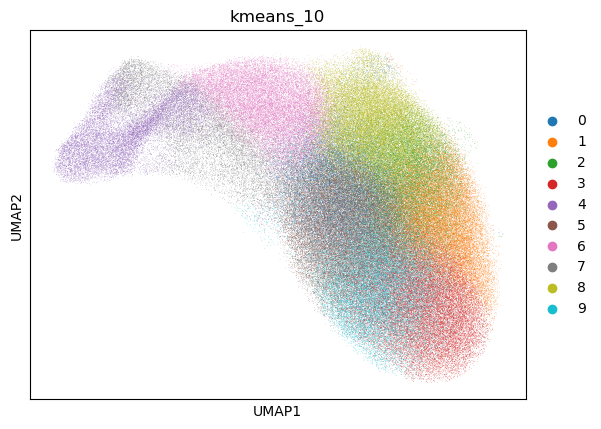

In [8]:
sc.settings.figdir = "./figs"
sc.pl.umap(adata_hvg, color=["kmeans_10"], save="_kmeans10_HGV.png")